导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import random

获取主数据集
test_data 为不可见数据集

In [2]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

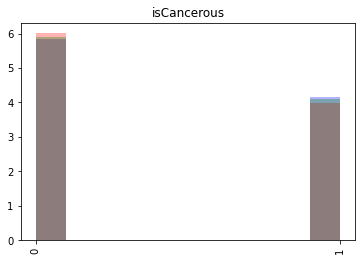

In [3]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

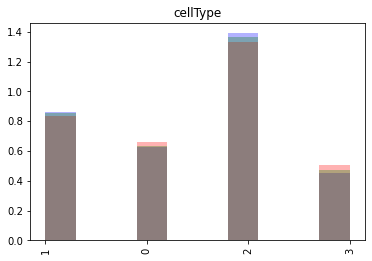

In [4]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [5]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [6]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [7]:
batch_size = 32
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [8]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


两层卷积一层池化，32，64。两层512感知器。

In [9]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                      

In [10]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [11]:
model_binary.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_categorical.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), metrics=['accuracy'])

In [12]:
epochs = 100
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100


2023-05-01 18:54:34.536411: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


197/197 [==============================] - 8s 36ms/step - loss: 14.6289 - accuracy: 0.8011 - val_loss: 14.0191 - val_accuracy: 0.4107 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 7s 34ms/step - loss: 13.3372 - accuracy: 0.8402 - val_loss: 12.5101 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 7s 34ms/step - loss: 12.2599 - accuracy: 0.8430 - val_loss: 11.3081 - val_accuracy: 0.8878 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 7s 35ms/step - loss: 11.2638 - accuracy: 0.8517 - val_loss: 10.4084 - val_accuracy: 0.8724 - lr: 1.0000e-04
Epoch 5/100
197/197 [==============================] - 7s 36ms/step - loss: 10.3877 - accuracy: 0.8551 - val_loss: 9.5396 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 6/100
197/197 [==============================] - 7s 35ms/step - loss: 9.5791 - accuracy: 0.8587 - val_loss: 8.7674 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 7/100
197/197 [================

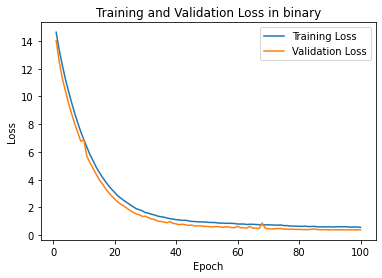

In [13]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

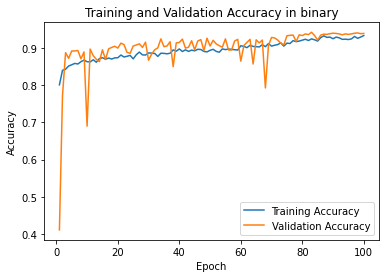

In [14]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [15]:
loss, accuracy = model_binary.evaluate(test_isCancerous_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 1s 21ms/step - loss: 0.4020 - accuracy: 0.9369
Loss: 0.4020, Accuracy: 0.9369


# 训练多分类

In [16]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 8s 39ms/step - loss: 19.1620 - accuracy: 0.5468 - val_loss: 15.9831 - val_accuracy: 0.4235 - lr: 5.0000e-04
Epoch 2/100
197/197 [==============================] - 8s 38ms/step - loss: 16.9044 - accuracy: 0.6098 - val_loss: 13.3886 - val_accuracy: 0.4566 - lr: 5.0000e-04
Epoch 3/100
197/197 [==============================] - 8s 39ms/step - loss: 14.9385 - accuracy: 0.6429 - val_loss: 11.1162 - val_accuracy: 0.6773 - lr: 5.0000e-04
Epoch 4/100
197/197 [==============================] - 8s 38ms/step - loss: 13.2577 - accuracy: 0.6590 - val_loss: 9.6443 - val_accuracy: 0.6760 - lr: 5.0000e-04
Epoch 5/100
197/197 [==============================] - 8s 39ms/step - loss: 11.7335 - accuracy: 0.6692 - val_loss: 8.6300 - val_accuracy: 0.5179 - lr: 5.0000e-04
Epoch 6/100
197/197 [==============================] - 8s 39ms/step - loss: 10.4179 - accuracy: 0.6667 - val_loss: 7.2871 - val_accuracy: 0.5421 - lr: 5.0000e-04
Epoch 7/100
197/197 [====

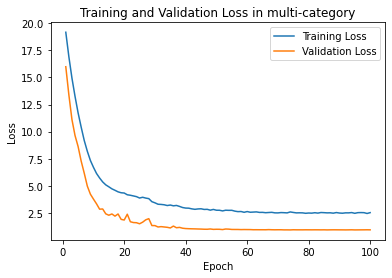

In [17]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

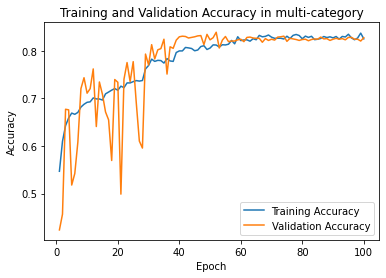

In [18]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [19]:
# # 预测
# predictions = model_categorical.predict(test_cellType_generator)
#
# # 获取预测标签
# predicted_labels = np.argmax(predictions, axis=-1)
#
# # 计算准确度
# true_labels = test_cellType_generator.classes
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
#
# # 计算损失
# y_true = tf.keras.utils.to_categorical(true_labels, num_classes=4) # 根据您的类别数量更改 num_classes
# loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, predictions))
# print(f"Loss: {loss}")

loss, accuracy = model_categorical.evaluate(test_cellType_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 1s 24ms/step - loss: 0.9887 - accuracy: 0.8162
Loss: 0.9887, Accuracy: 0.8162


In [20]:
model_categorical.save('saved_model/model_categorical')

INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [33]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical')
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
# data_extra['cellType'] = np.nan
# data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
# data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
# data_extra_labeled = data_extra[data_extra['cellType'] == 2]
# undivided_train_data = pd.concat([undivided_train_data, data_extra_labeled], axis=0).reset_index(drop=True)
# undivided_train_data['cellType'] = undivided_train_data['cellType'].astype(int)
# train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

In [22]:
# cellType(多分类)的比例
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}
#
# data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)

重新生成新的train_generator

In [34]:
batch_size = 32
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 10384 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 4 classes.


## UDA实现

In [24]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomFlip("vertical"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
#     tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
#     tf.keras.layers.RandomContrast(factor=(0.8, 1.2)),
#     tf.keras.layers.RandomBrightness(factor=0.1),
# ])

In [35]:
# 定义数据增强层
class RandAugment(tf.keras.layers.Layer):
    def __init__(self, num_layers, magnitude, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.magnitude = magnitude
        self.operations = [
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(1 - 0.1 * magnitude, 1 + 0.1 * magnitude)),
            tf.keras.layers.RandomBrightness(factor=(0.2 * magnitude)),
        ]

    def call(self, inputs, **kwargs):
        if kwargs.get('training'):
            for _ in range(self.num_layers):
                operation = random.choice(self.operations)
                inputs = operation(inputs, training=kwargs.get('training'))
        return inputs

In [37]:
def apply_uda(x_batch, y_batch, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1.5, confidence_threshold=0.5, temperature=0.5):
    x_unlabeled_augmented = None
    if x_unlabeled is not None:
        # 对无标签数据进行数据增强
        # x_unlabeled_augmented = data_augmentation(x_unlabeled)
        rand_augment = RandAugment(num_layers=3, magnitude=0.9)
        x_unlabeled_augmented = rand_augment(x_unlabeled, training=training)

    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x_batch)
        if x_unlabeled is not None:
            y_pred_unlabeled = model(x_unlabeled)
            y_pred_unlabeled_augmented = model(x_unlabeled_augmented)

            # Sharpening Predictions
            y_pred_unlabeled = tf.nn.softmax(y_pred_unlabeled / temperature, axis=-1)
            y_pred_unlabeled_augmented = tf.nn.softmax(y_pred_unlabeled_augmented / temperature, axis=-1)

            # Confidence-based masking
            max_probs = tf.reduce_max(y_pred_unlabeled, axis=-1)
            mask = max_probs > confidence_threshold
            y_pred_unlabeled = tf.boolean_mask(y_pred_unlabeled, mask)
            y_pred_unlabeled_augmented = tf.boolean_mask(y_pred_unlabeled_augmented, mask)

        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            sample_weights = tf.gather(class_weight_dict, tf.argmax(y_batch, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            consistency_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_pred_unlabeled, y_pred_unlabeled_augmented))
            total_loss = supervised_loss + consistency_weight * consistency_loss
        else:
            total_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(total_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss if x_unlabeled is not None else None, accuracy

### 训练半监督

In [38]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1e-5)
epochs = 5
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = optimizer.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
            progress_bar.update(1)
            loss, supervised_loss, consistency_loss, accuracy = apply_uda(x_batch,
                                                                          y_batch,
                                                                          x_unlabeled,
                                                                          model_categorical,
                                                                          optimizer,
                                                                          class_weight_dict_cellType)
            total_loss += loss
            total_supervised_loss += supervised_loss
            total_consistency_loss += consistency_loss
            total_accuracy += tf.reduce_mean(accuracy)
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        loss, _, _, accuracy = apply_uda(x_batch, y_batch, None, model_categorical, optimizer, False)
        total_loss += loss
        total_accuracy += tf.reduce_mean(accuracy)
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps
    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())
    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, learning rate: {current_learning_rate}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1

    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        optimizer.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:23<00:00,  8.26it/s]


 - loss: 0.5081, supervised_loss: 0.3993, consistency_loss: 0.0725, accuracy: 0.8560
Validation set： - loss: 0.4281, accuracy: 0.8342, learning rate: 9.999999974752427e-07
Epoch 2/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:23<00:00,  8.35it/s]


 - loss: 0.4874, supervised_loss: 0.3878, consistency_loss: 0.0664, accuracy: 0.8586
Validation set： - loss: 0.4480, accuracy: 0.8281, learning rate: 9.999999974752427e-07
Epoch 3/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:23<00:00,  8.39it/s]


 - loss: 0.4724, supervised_loss: 0.3926, consistency_loss: 0.0532, accuracy: 0.8553
Validation set： - loss: 0.4110, accuracy: 0.8367, learning rate: 9.999999974752427e-07
Epoch 4/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:24<00:00,  8.22it/s]


 - loss: 0.4577, supervised_loss: 0.3881, consistency_loss: 0.0464, accuracy: 0.8626
Validation set： - loss: 0.4484, accuracy: 0.8281, learning rate: 9.999999974752427e-07
Epoch 5/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:24<00:00,  8.15it/s]


 - loss: 0.4628, supervised_loss: 0.3882, consistency_loss: 0.0497, accuracy: 0.8615
Validation set： - loss: 0.4186, accuracy: 0.8377, learning rate: 3.162277652184396e-07


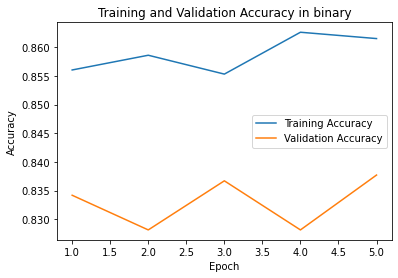

In [39]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [40]:
loss, accuracy = model_categorical.evaluate(test_cellType_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

62/62 [==============================] - 2s 25ms/step - loss: 0.9703 - accuracy: 0.8288
Loss: 0.9703, Accuracy: 0.8288
